In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import keras.backend as K

from dataset import load_dataset, polyfit, expfit, shuffle_apply_scaler, perm_distribution
from model import MSE_function, huber_fn, MSE_model, huber_model

from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
from keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteError
from keras.callbacks import ModelCheckpoint,EarlyStopping


In [2]:
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Num GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9



In [3]:
df, perm_df, param_df, time_df = load_dataset('../dataset/CombinedDataset.xlsx', '1')
means, Distribution = perm_distribution(df)
X1_arr_train_shuffle, X2_arr_train_shuffle, Y_arr_train_shuffle, X1_arr_valid_shuffle, X2_arr_valid_shuffle, Y_arr_valid_shuffle, X1_arr_test_shuffle, X2_arr_test_shuffle, Y_arr_test_shuffle, timestamp_test = shuffle_apply_scaler(df, perm_df, param_df, time_df)

c:\Users\admin\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\admin\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\admin\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [4]:
offset = 1.0
ic_pt = means[330]
multiplier = 5.0

y_max = np.max(Distribution[0]).astype('float32')
y_min = np.min(Distribution[0]).astype('float32')

p_list = polyfit(df)
a_fit, b_fit, c_fit = expfit(df)

def custom_loss_function(y_true, y_pred):
    delta = 5
    diff = y_true - y_pred
    is_small_error = tf.abs(diff) < delta
    squared_loss = tf.square(diff) / 2
    linear_loss  = tf.multiply(tf.abs(diff), delta) - 0.5 * delta**2
    error = tf.where(is_small_error, squared_loss, linear_loss)
    is_small_value = y_true < ic_pt
    polynomial_term = tf.math.polyval(p_list, y_true)
    a_fit_float32 = tf.cast(a_fit, dtype=tf.float32)
    b_fit_float32 = tf.cast(b_fit, dtype=tf.float32)
    c_fit_float32 = tf.cast(c_fit, dtype=tf.float32)
    exp_term = tf.add(tf.multiply(a_fit_float32, tf.exp(tf.multiply(-1*b_fit_float32, y_true))), c_fit_float32)
    clf_coe = tf.where(is_small_value, polynomial_term, exp_term)
    clf_coe_reversed = tf.add(offset,tf.divide(tf.subtract(y_max, clf_coe), tf.subtract(y_max, y_min)))
    return K.mean(tf.multiply(tf.multiply(multiplier, clf_coe_reversed), error))

def clf_model(index, 
              X1_arr_train_shuffle, 
              X2_arr_train_shuffle, 
              Y_arr_train_shuffle, 
              X1_arr_valid_shuffle, 
              X2_arr_valid_shuffle,
              Y_arr_valid_shuffle):
    num_encoder_features = 3  # Number of input features
    num_decoder_features = 6
    encoder_seq_len = 900
    decoder_seq_len = 180
    hidden_dim = 16  # Hidden dimension of LSTM
    hidden_dim2 = 8
    dropout_rate = 0.1
    learning_rate = 0.005

    # Build the encoder
    encoder_inputs = tf.keras.Input(shape=(encoder_seq_len, num_encoder_features))
    encoder_lstm1 = LSTM(hidden_dim, return_state=True, return_sequences=True)
    encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)
    encoder_outputs1 = Dropout(dropout_rate)(encoder_outputs1)
    encoder_lstm2 = LSTM(hidden_dim2, return_state=True, return_sequences=True)
    encoder_outputs2, state_h, state_c = encoder_lstm2(encoder_outputs1)
    encoder_states = [state_h, state_c]

    # Build the decoder
    decoder_inputs = tf.keras.Input(shape=(decoder_seq_len, num_decoder_features))
    decoder_lstm = LSTM(hidden_dim2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense_1 = Dense(hidden_dim2/2,activation='relu')
    decoder_outputs = decoder_dense_1(decoder_outputs)
    decoder_dense_2 = Dense(1)
    decoder_outputs = decoder_dense_2(decoder_outputs)

    # Build the model
    model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=custom_loss_function,metrics=[RootMeanSquaredError(),MeanAbsolutePercentageError(),MeanAbsoluteError()])
    model.summary()
    
    batch_size = 1024
    epochs = 200
    
    folder_name = './model/'
    file_name = 'R168_Dropout.1_bs1024_lr0.005_Delta5_CLFHuber5_Adam' + str(index)

    cp1 = ModelCheckpoint(
        filepath=folder_name + file_name + '.h5',
        save_best_only=True, verbose=1
    )

    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    # early_stopping = EarlyStopping(patience=10, restore_best_weights=True, start_from_epoch=60)
    
    # Train the model
    history=model.fit([X1_arr_train_shuffle, X2_arr_train_shuffle], Y_arr_train_shuffle, validation_data=([X1_arr_valid_shuffle, X2_arr_valid_shuffle], Y_arr_valid_shuffle),
                 epochs=epochs, batch_size=batch_size,
                 callbacks=[cp1,early_stopping])
    return history

In [6]:
metric_dic = {
    'CLF': 'loss',
    'RMSE': 'root_mean_squared_error',
    'MAPE': 'mean_absolute_percentage_error',
    'MSE': 'root_mean_squared_error',
    'MAE': 'mean_absolute_error'}

def loss_metric_plot(history, save_location, metric_name_str):
    history.history.keys()
    plt.clf()
    plt.plot(history.history[metric_dic[metric_name_str]], label='Training ' + metric_name_str)
    plt.plot(history.history['val_' + metric_dic[metric_name_str]], label='Validation ' + metric_name_str)
    plt.ylabel(metric_name_str)
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(save_location + '_' + metric_name_str + '.png')
    plt.show()
    return plt.show


In [ ]:
history = clf_model(0, 
                    X1_arr_train_shuffle, 
                    X2_arr_train_shuffle, 
                    Y_arr_train_shuffle, 
                    X1_arr_valid_shuffle, 
                    X2_arr_valid_shuffle,
                    Y_arr_valid_shuffle)
folder_name = './model/'
file_name = 'R168_Dropout.1_bs1024_lr0.005_Delta5_CLFHuber5_Adam' + str(0)
loss_metric_plot(history, folder_name + 'graph/' + file_name, 'CLF')
loss_metric_plot(history, folder_name + 'graph/' + file_name, 'MAPE')
loss_metric_plot(history, folder_name + 'graph/' + file_name, 'RMSE')
loss_metric_plot(history, folder_name + 'graph/' + file_name, 'MAE')

# #train multiple models
# for i in range(10):
#     history = clf_model(i)
#     folder_name = './model/'
#     file_name = 'R168_Dropout.1_bs1024_lr0.005_Delta5_CLFHuber5_Adam' + str(i)
#     loss_metric_plot(history, folder_name + 'graph/' + file_name, 'CLF')
#     loss_metric_plot(history, folder_name + 'graph/' + file_name, 'MAPE')
#     loss_metric_plot(history, folder_name + 'graph/' + file_name, 'RMSE')
#     loss_metric_plot(history, folder_name + 'graph/' + file_name, 'MAE')

In [ ]:
history = MSE_model(0, 
                    X1_arr_train_shuffle, 
                    X2_arr_train_shuffle, 
                    Y_arr_train_shuffle, 
                    X1_arr_valid_shuffle, 
                    X2_arr_valid_shuffle,
                    Y_arr_valid_shuffle)
folder_name = './model/'
file_name = 'R168_Dropout.1_bs1024_lr0.005_MSE' + str(0)
loss_metric_plot(history, folder_name + 'graph/' + file_name, 'CLF')
loss_metric_plot(history, folder_name + 'graph/' + file_name, 'MAPE')
loss_metric_plot(history, folder_name + 'graph/' + file_name, 'RMSE')
loss_metric_plot(history, folder_name + 'graph/' + file_name, 'MAE')

# #train multiple models
# for i in range(10):
#     history = MSE_model(i, 
#                     X1_arr_train_shuffle, 
#                     X2_arr_train_shuffle, 
#                     Y_arr_train_shuffle, 
#                     X1_arr_valid_shuffle, 
#                     X2_arr_valid_shuffle,
#                     Y_arr_valid_shuffle)
#     folder_name = './model/'
#     file_name = 'R168_Dropout.1_bs1024_lr0.005_MSE' + str(i)
#     loss_metric_plot(history, folder_name + 'graph/' + file_name, 'CLF')
#     loss_metric_plot(history, folder_name + 'graph/' + file_name, 'MAPE')
#     loss_metric_plot(history, folder_name + 'graph/' + file_name, 'RMSE')
#     loss_metric_plot(history, folder_name + 'graph/' + file_name, 'MAE')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 900, 3)]     0           []                               
                                                                                                  
 lstm_3 (LSTM)                  [(None, 900, 16),    1280        ['input_3[0][0]']                
                                 (None, 16),                                                      
                                 (None, 16)]                                                      
                                                                                                  
 dropout_1 (Dropout)            (None, 900, 16)      0           ['lstm_3[0][0]']                 
                                                                                            

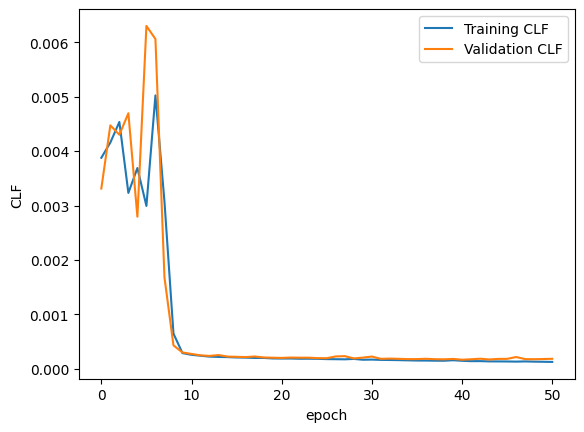

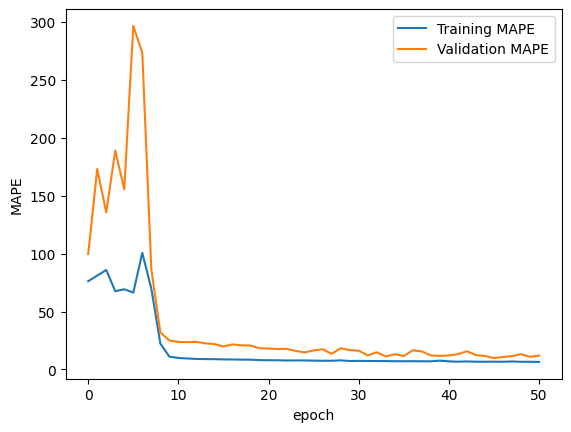

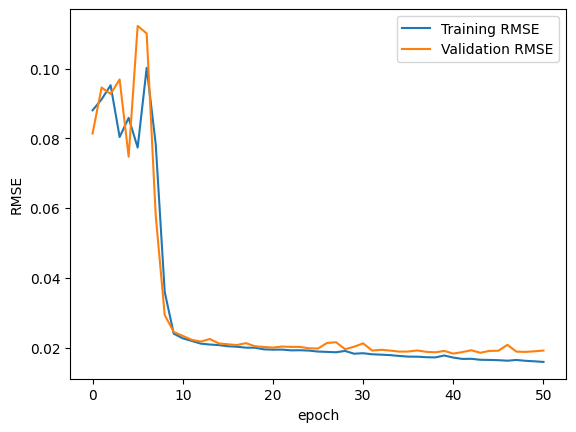

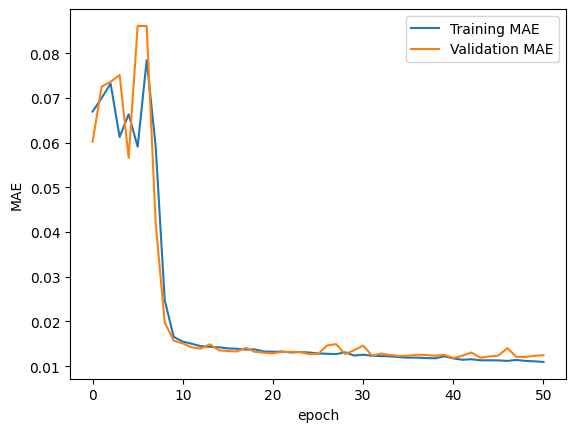

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 900, 3)]     0           []                               
                                                                                                  
 lstm_6 (LSTM)                  [(None, 900, 16),    1280        ['input_5[0][0]']                
                                 (None, 16),                                                      
                                 (None, 16)]                                                      
                                                                                                  
 dropout_2 (Dropout)            (None, 900, 16)      0           ['lstm_6[0][0]']                 
                                                                                            

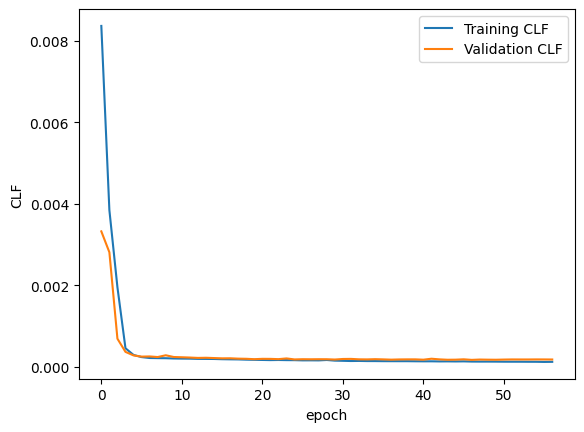

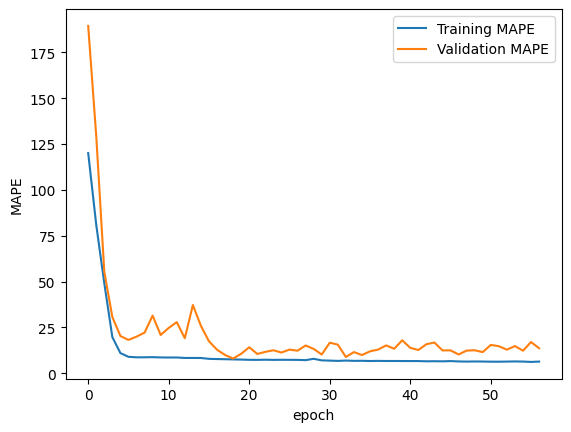

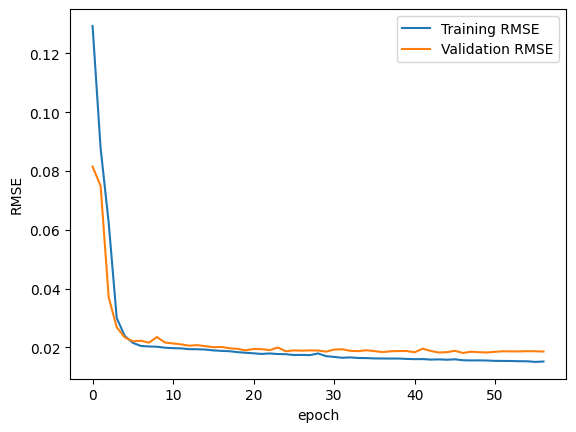

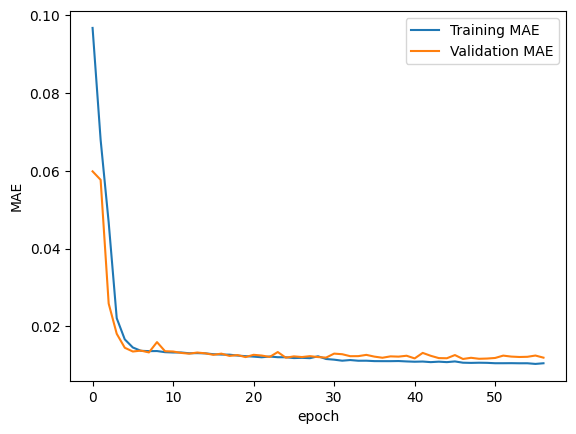

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 900, 3)]     0           []                               
                                                                                                  
 lstm_9 (LSTM)                  [(None, 900, 16),    1280        ['input_7[0][0]']                
                                 (None, 16),                                                      
                                 (None, 16)]                                                      
                                                                                                  
 dropout_3 (Dropout)            (None, 900, 16)      0           ['lstm_9[0][0]']                 
                                                                                            

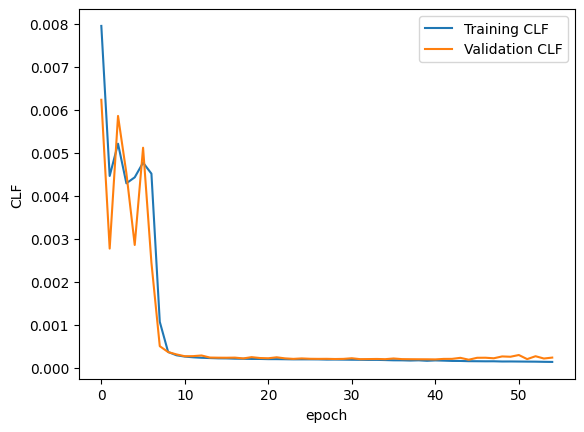

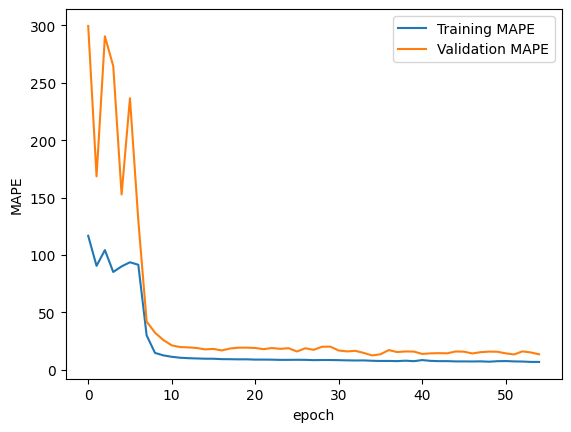

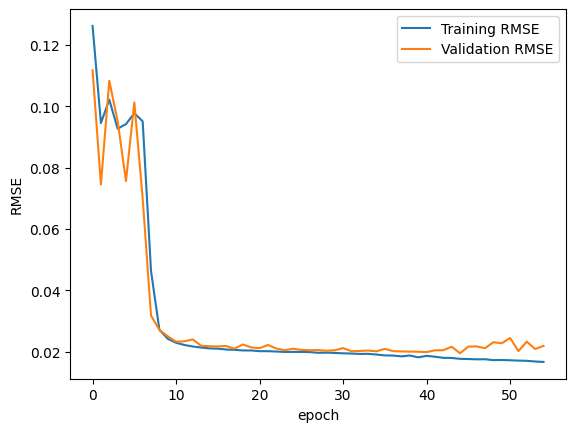

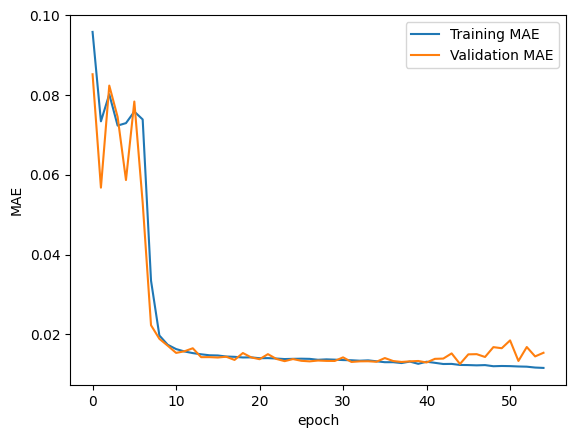

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 900, 3)]     0           []                               
                                                                                                  
 lstm_12 (LSTM)                 [(None, 900, 16),    1280        ['input_9[0][0]']                
                                 (None, 16),                                                      
                                 (None, 16)]                                                      
                                                                                                  
 dropout_4 (Dropout)            (None, 900, 16)      0           ['lstm_12[0][0]']                
                                                                                            

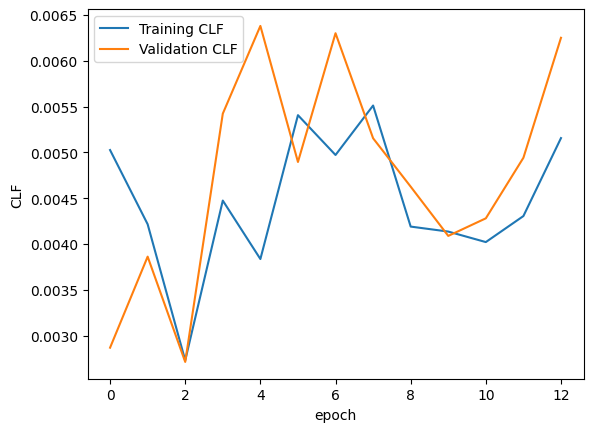

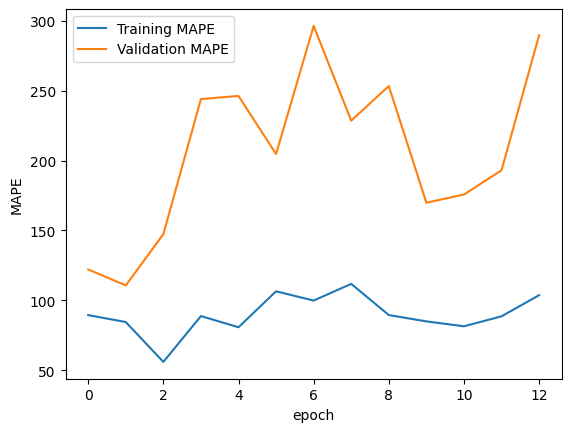

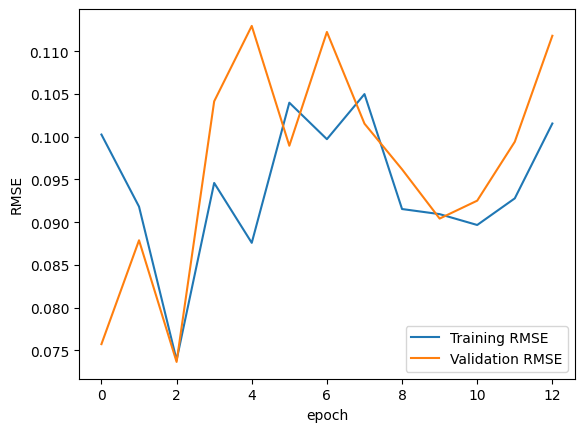

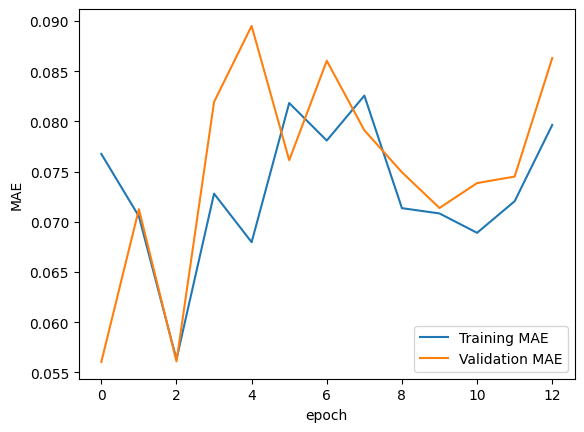

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 900, 3)]     0           []                               
                                                                                                  
 lstm_15 (LSTM)                 [(None, 900, 16),    1280        ['input_11[0][0]']               
                                 (None, 16),                                                      
                                 (None, 16)]                                                      
                                                                                                  
 dropout_5 (Dropout)            (None, 900, 16)      0           ['lstm_15[0][0]']                
                                                                                            

: 

In [9]:
history = huber_model(0, 
                    X1_arr_train_shuffle, 
                    X2_arr_train_shuffle, 
                    Y_arr_train_shuffle, 
                    X1_arr_valid_shuffle, 
                    X2_arr_valid_shuffle,
                    Y_arr_valid_shuffle)
folder_name = './model/'
file_name = 'R1616_Dropout.1_bs1024_lr0.005_Huber5_softmax' + str(0)
loss_metric_plot(history, folder_name + 'graph/' + file_name, 'CLF')
loss_metric_plot(history, folder_name + 'graph/' + file_name, 'MAPE')
loss_metric_plot(history, folder_name + 'graph/' + file_name, 'RMSE')
loss_metric_plot(history, folder_name + 'graph/' + file_name, 'MAE')

# #train multiple models
# for i in range(5):
#     history = huber_model(i, 
#                     X1_arr_train_shuffle, 
#                     X2_arr_train_shuffle, 
#                     Y_arr_train_shuffle, 
#                     X1_arr_valid_shuffle, 
#                     X2_arr_valid_shuffle,
#                     Y_arr_valid_shuffle)
#     folder_name = './model/'
#     file_name = 'R1616_Dropout.1_bs1024_lr0.005_Huber5_softmax' + str(i)
#     loss_metric_plot(history, folder_name + 'graph/' + file_name, 'CLF')
#     loss_metric_plot(history, folder_name + 'graph/' + file_name, 'MAPE')
#     loss_metric_plot(history, folder_name + 'graph/' + file_name, 'RMSE')
#     loss_metric_plot(history, folder_name + 'graph/' + file_name, 'MAE')